Visualisation of JohnsonJohnson dataset


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.440   1.248   3.510   4.800   7.133  16.200 

[1] 4.309991

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”


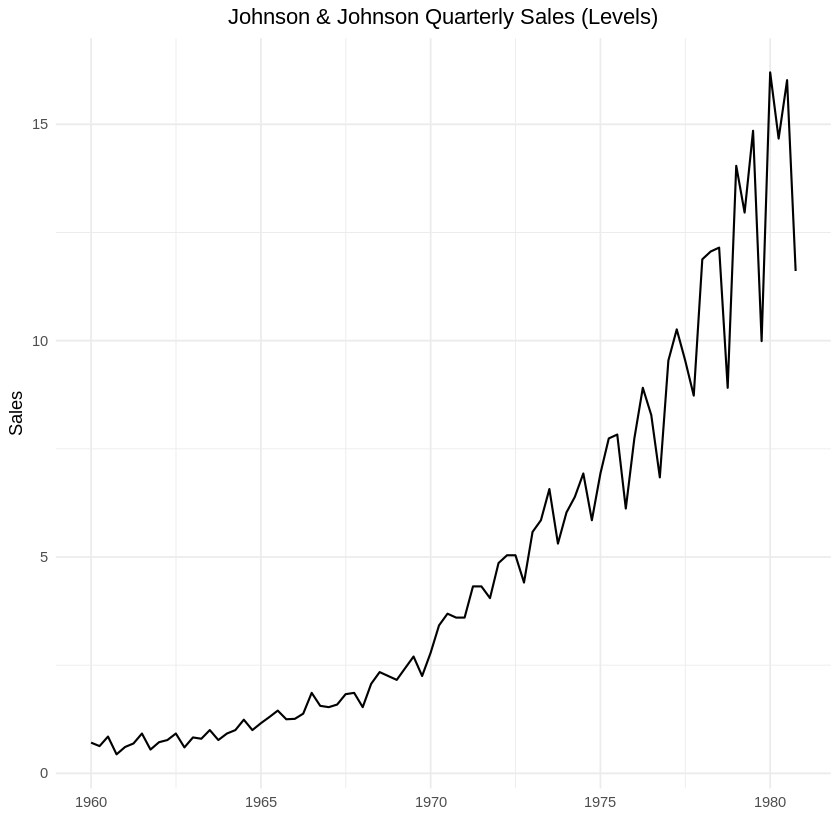

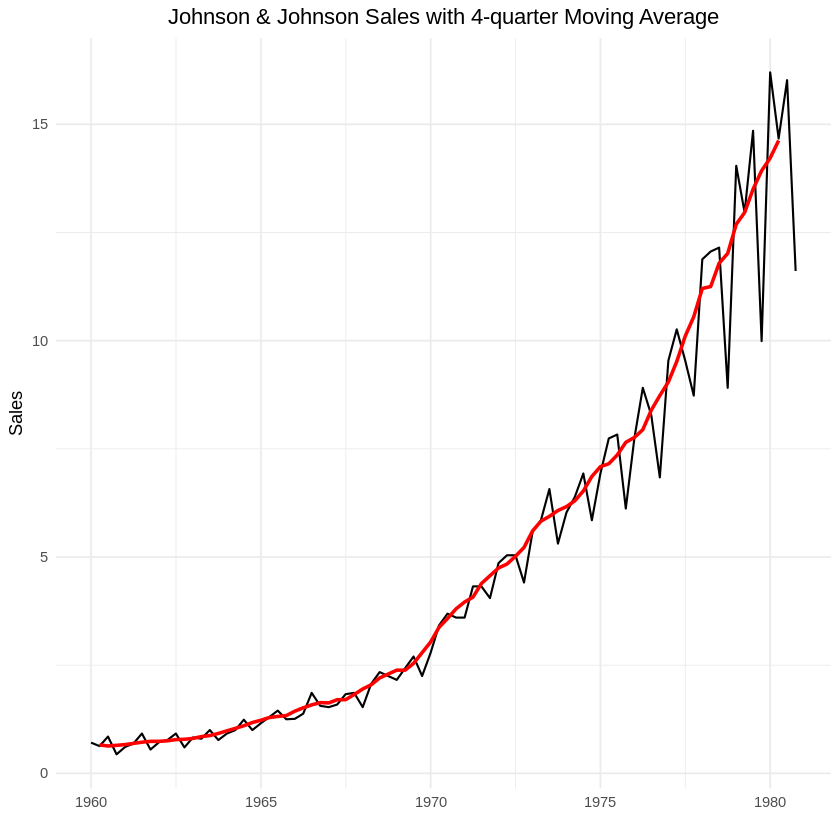

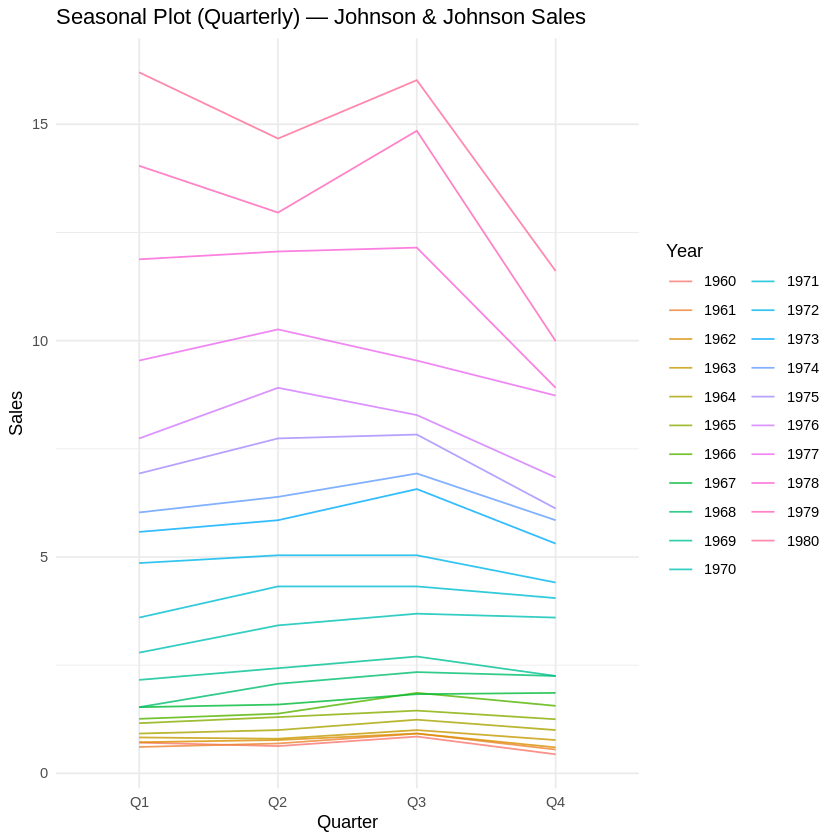

In [1]:
# Load required packages
# These packages handle time series data, plotting,
# date manipulation, and basic data wrangling.
required <- c("zoo", "ggplot2", "dplyr", "lubridate", "scales")
for (p in required) {
  if (!requireNamespace(p, quietly = TRUE)) {
    install.packages(p, repos = "https://cran.r-project.org")
  }
  suppressPackageStartupMessages(library(p, character.only = TRUE))
}

# Load Johnson & Johnson quarterly sales data (built-in)
data("JohnsonJohnson")

# Convert the time series object into a clean data frame
# This makes it easier to manipulate and plot using ggplot2.
jj_df <- data.frame(
  date = as.Date(time(JohnsonJohnson)),
  sales = as.numeric(JohnsonJohnson)
) %>%
  arrange(date)

# Quick exploratory data analysis (EDA)
# Summary statistics give a fast sense of scale,
# variability, and distribution of the series.
summary(jj_df$sales)
sd(jj_df$sales)

# Add time-related variables and a 4-quarter moving average
# - year and quarter help with seasonal analysis
# - MA4 smooths short-term fluctuations to highlight trend
jj_df <- jj_df %>%
  mutate(
    year = year(date),
    quarter = quarter(date),
    quarter_label = paste0("Q", quarter),
    MA4 = zoo::rollmean(sales, k = 4, fill = NA, align = "center")
  )

base_theme <- theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

# --------------------------------------------------
# Plot 1: Time plot of sales (levels)
# Shows how sales evolve over time, revealing
# long-run growth and overall structure.
# --------------------------------------------------
p1 <- ggplot(jj_df, aes(x = date, y = sales)) +
  geom_line(color = "black", size = 0.6) +
  labs(
    title = "Johnson & Johnson Quarterly Sales (Levels)",
    y = "Sales",
    x = ""
  ) +
  scale_x_date(
    labels = scales::date_format("%Y"),
    breaks = scales::pretty_breaks(n = 8)
  ) +
  base_theme

print(p1)

# --------------------------------------------------
# Plot 2: Time plot with 4-quarter moving average
# The red line smooths quarterly noise and makes
# the underlying trend easier to see.
# --------------------------------------------------
p2 <- ggplot(jj_df, aes(x = date)) +
  geom_line(aes(y = sales), color = "black", size = 0.6) +
  geom_line(aes(y = MA4), color = "red", size = 1) +
  labs(
    title = "Johnson & Johnson Sales with 4-quarter Moving Average",
    y = "Sales",
    x = ""
  ) +
  scale_x_date(
    labels = scales::date_format("%Y"),
    breaks = scales::pretty_breaks(n = 8)
  ) +
  base_theme

print(p2)

# --------------------------------------------------
# Plot 3: Seasonal plot by quarter
# Each line represents one year.
# This highlights repeating within-year patterns
# and makes quarterly seasonality visible.
# --------------------------------------------------
season_df <- jj_df %>%
  mutate(year_f = factor(year))

p3 <- ggplot(
  season_df,
  aes(x = quarter_label, y = sales, group = year_f, color = year_f)
) +
  geom_line(alpha = 0.8) +
  labs(
    title = "Seasonal Plot (Quarterly) — Johnson & Johnson Sales",
    x = "Quarter",
    y = "Sales",
    color = "Year"
  ) +
  theme_minimal()

print(p3)

Visualisation of GDPC1 Data

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’


Loading required package: xts


######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to stop           #
# dplyr from breaking base R's lag() function.                                #
#                                                                             #
# Code in packages is not affected. I

[1] "GDPC1"

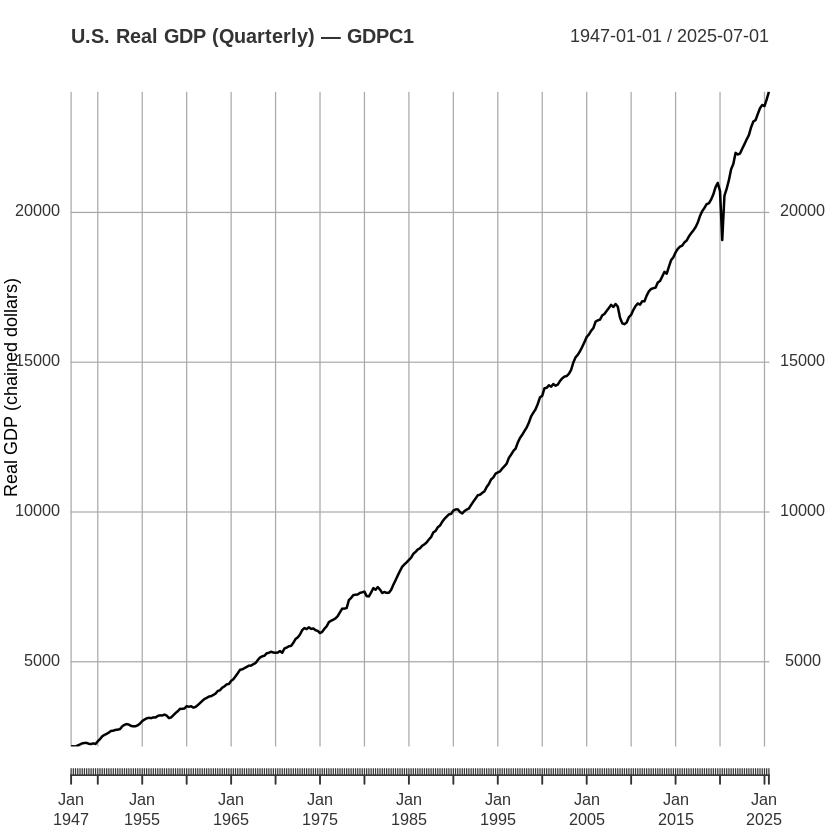

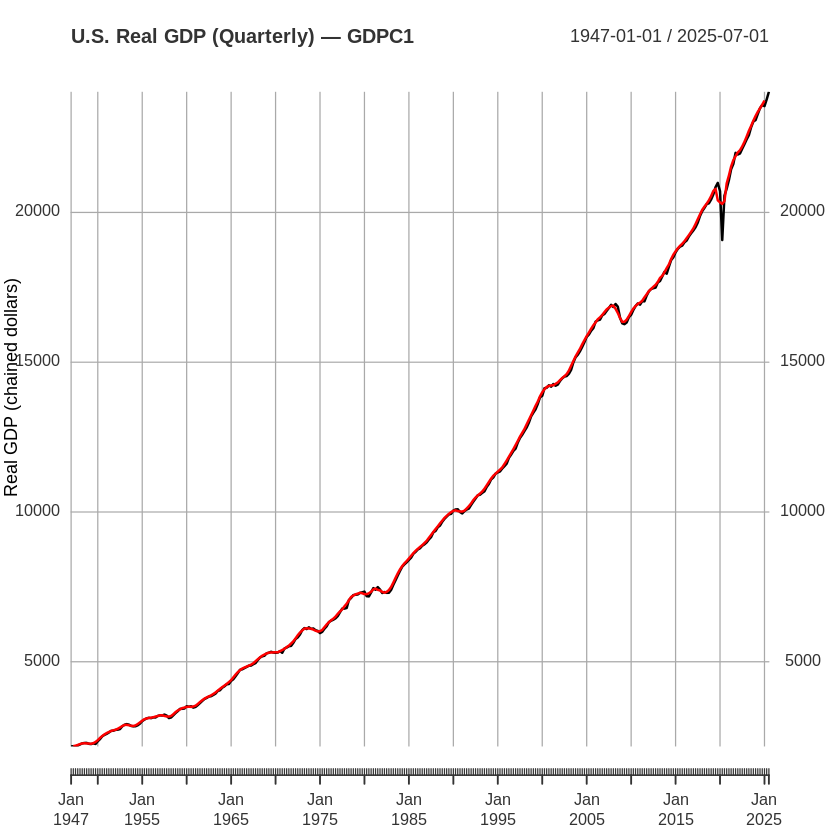

In [2]:
# We use the quantmod package, which supports quantitative financial
# and economic time-series analysis. It provides tools to download,
# manage, and visualise time-series data, including direct access to
# FRED (e.g. GDPC1).

install.packages("quantmod")
library(quantmod)

# Get real GDP from FRED
getSymbols("GDPC1", src = "FRED")

# Basic plot of the series
plot(GDPC1,
     main = "U.S. Real GDP (Quarterly) — GDPC1",
     ylab = "Real GDP (chained dollars)",
     xlab = "Year")

# Add a simple 4-quarter moving average
# The red line smooths quarterly noise and makes
# the underlying trend easier to see.
if (!require(zoo)) install.packages("zoo")
library(zoo)
lines(rollmean(GDPC1, k = 4, align = "center", fill = NA),
      col = "red", lwd = 2)

Choice of Model (Additive vs Multiplicative)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "GDPC1"

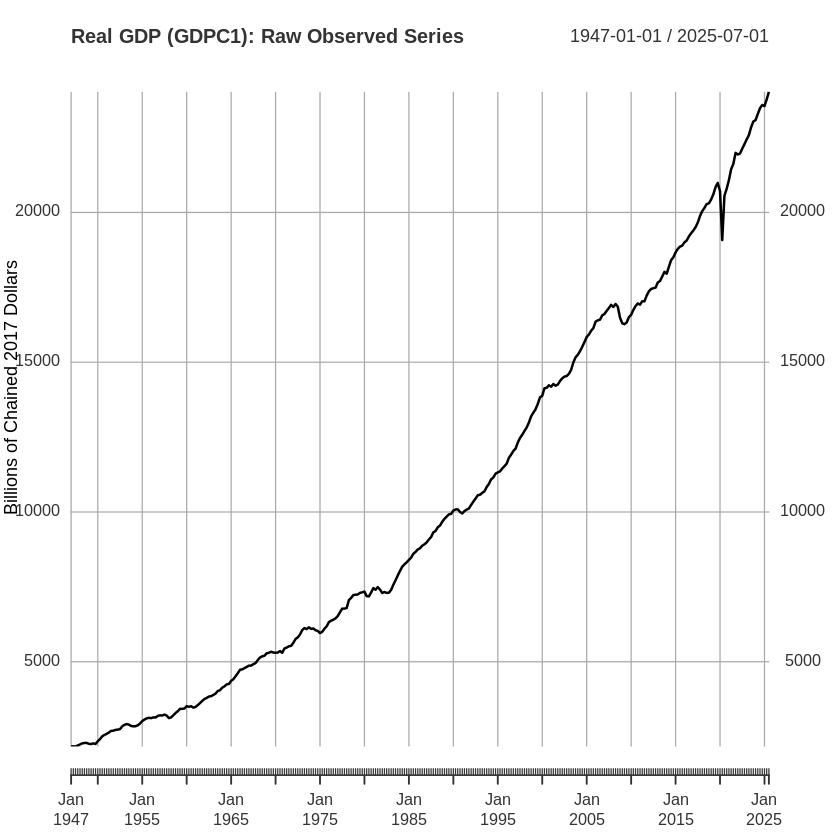

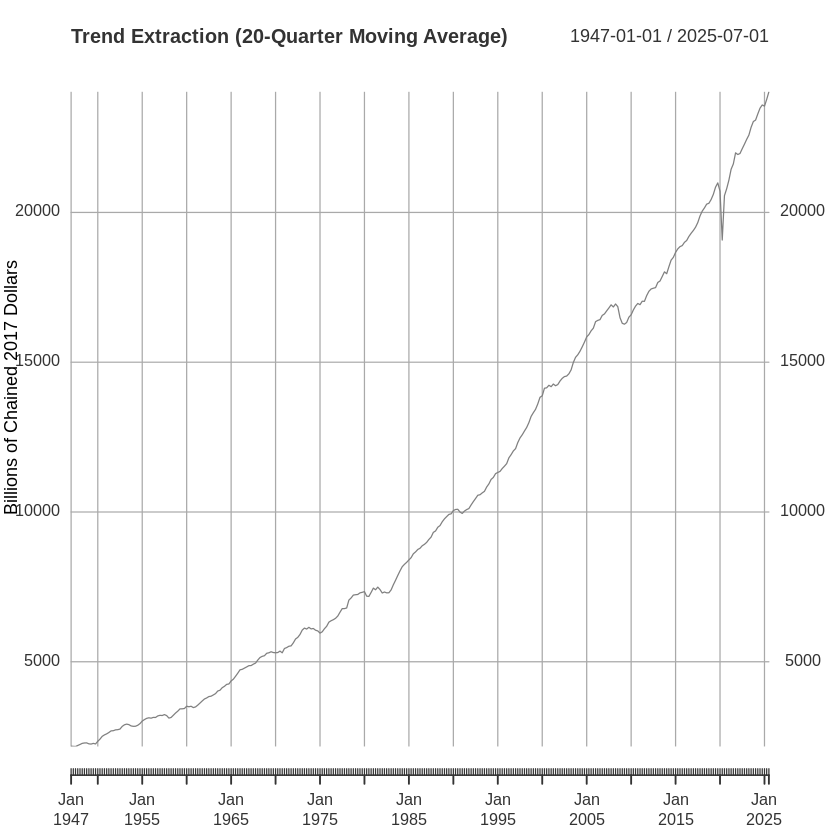

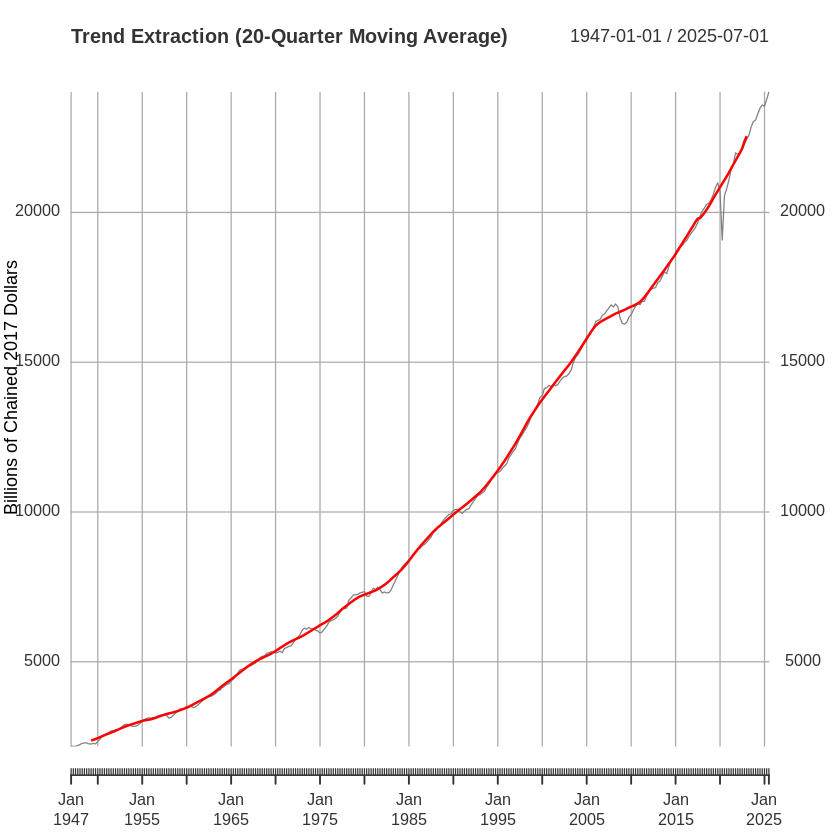

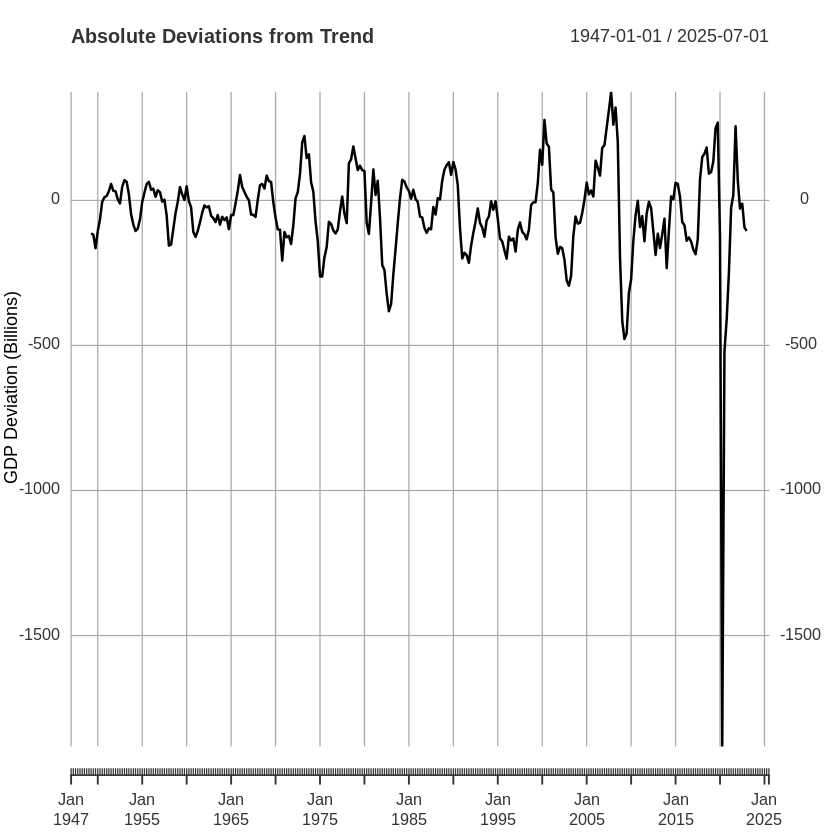

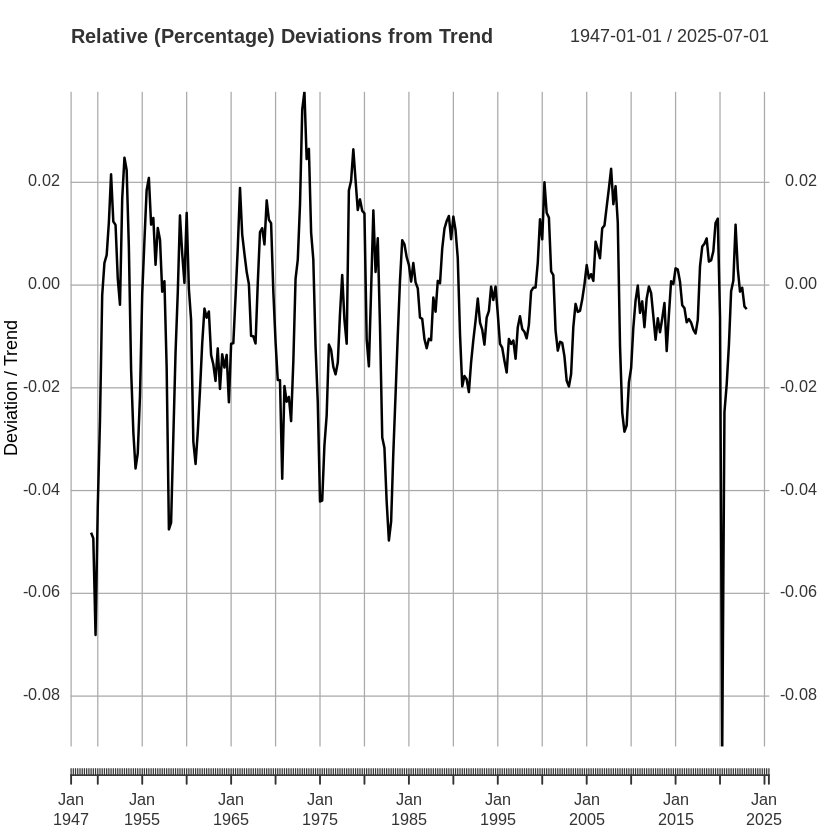

In [3]:
### Before choosing a model, we first study how the series behaves at different scales.
### We begin with the raw data, define a reference trend, examine deviations,
### and then decide whether an additive or multiplicative structure is appropriate.


######### Loading libraries #########
install.packages("quantmod")
library(quantmod)



######### Load GDP data #########
# Quarterly Real GDP (GDPC1) from FRED,
# seasonally adjusted annual rate (SAAR), long historical span
getSymbols("GDPC1", src = "FRED")
GDP_time_series <- GDPC1



######### Raw GDP series #########
plot(
  GDP_time_series,
  type = "l",
  main = "Real GDP (GDPC1): Raw Observed Series",
  xlab = "Time",
  ylab = "Billions of Chained 2017 Dollars"
)
### At this point we ask:
### - Is there a long-run direction?
### - Do fluctuations remain constant in size or scale with GDP?



######### Trend Extraction and Deviation Calculation #########
### Diagnostic trend using centered moving average
trend <- rollmean(GDP_time_series, k = 20, align = "center", fill = NA)
### 20-quarter MA captures long-run movement only.

plot(
  GDP_time_series,
  type = "l",
  col = "grey50",
  lwd = 1,
  main = "Trend Extraction (20-Quarter Moving Average)",
  xlab = "Time",
  ylab = "Billions of Chained 2017 Dollars"
)

lines(
  trend,
  col = "red",
  lwd = 2
)

legend(
  "topleft",
  legend = c("Observed", "Trend (20Q Moving Avg)"),
  col = c("grey50", "red"),
  lwd = c(1, 2),
  bty = "n"
)




######## Additive Decomposition (Diagnostic) #########
### Absolute deviations from trend
abs_dev <- GDP_time_series - trend

plot(
  abs_dev,
  type = "l",
  main = "Absolute Deviations from Trend",
  xlab = "Time",
  ylab = "GDP Deviation (Billions)"
)
abline(h = 0, lty = 2)
### Deviations grow with GDP → weak additive case



######## Multiplicative Decomposition (Diagnostic) #########
### Relative deviations from trend
rel_dev <- (GDP_time_series - trend) / trend

plot(
  rel_dev,
  type = "l",
  main = "Relative (Percentage) Deviations from Trend",
  xlab = "Time",
  ylab = "Deviation / Trend"
)
abline(h = 0, lty = 2)
### Relative deviations are more stable → supports multiplicative structure

Breaking Down Time Series Components

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "GDPC1"

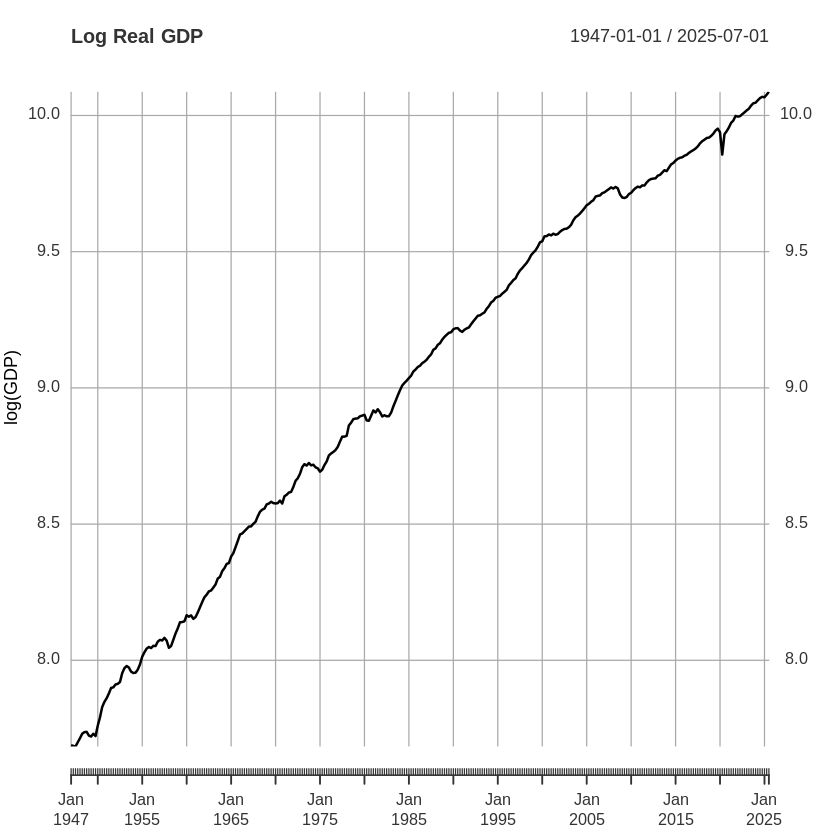

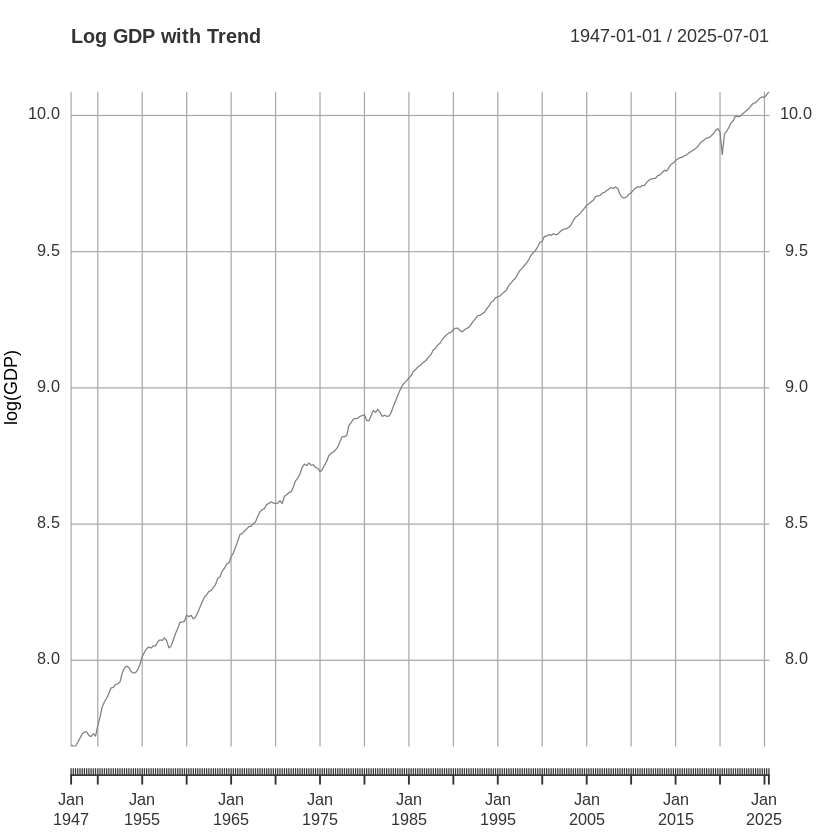

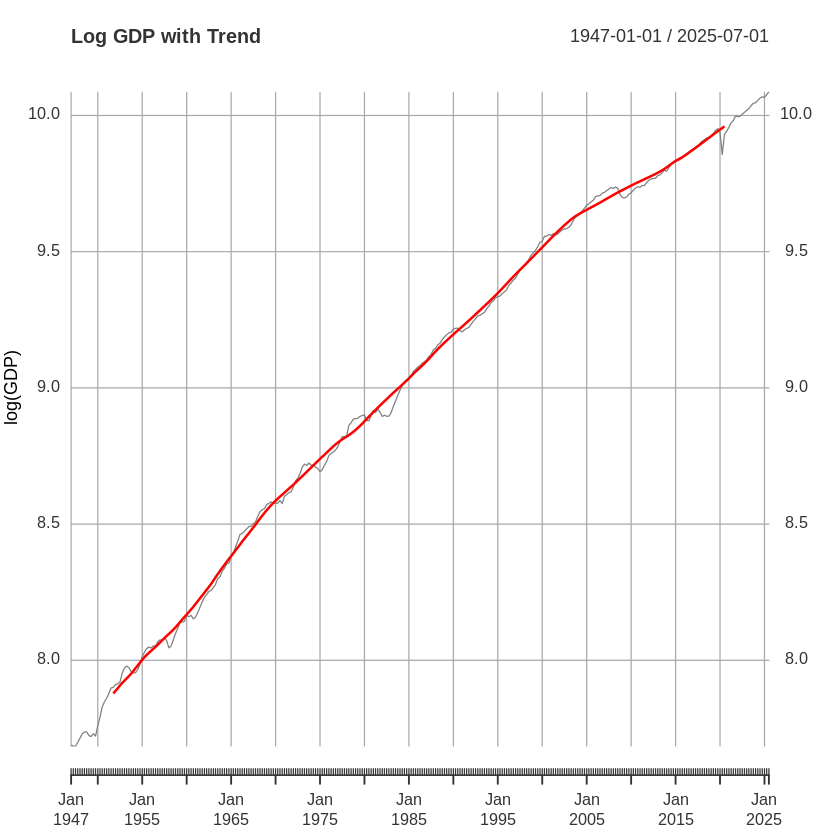

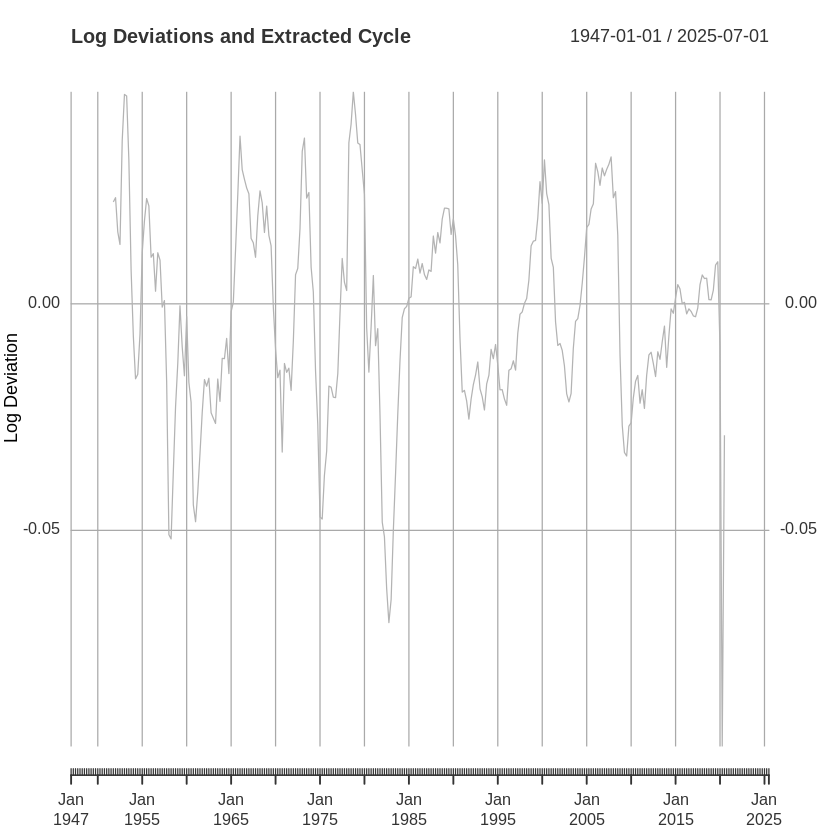

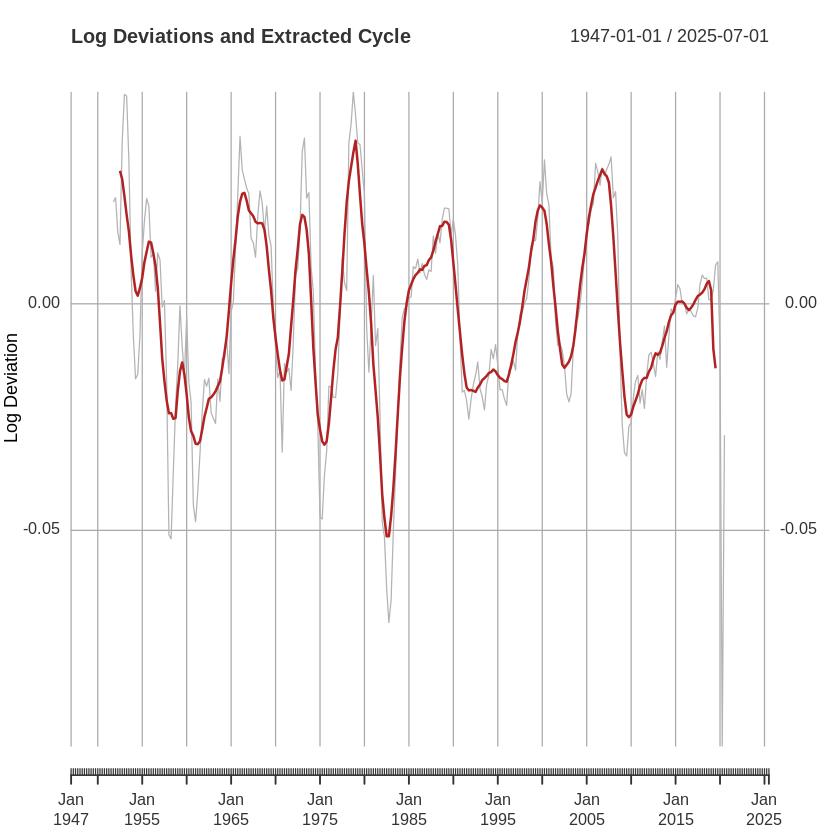

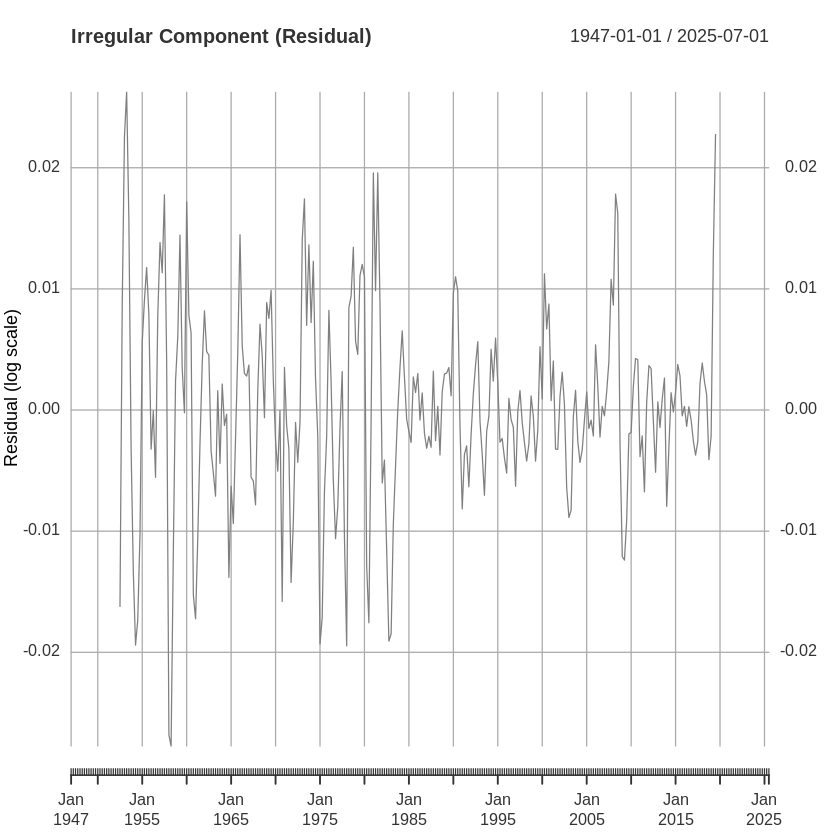

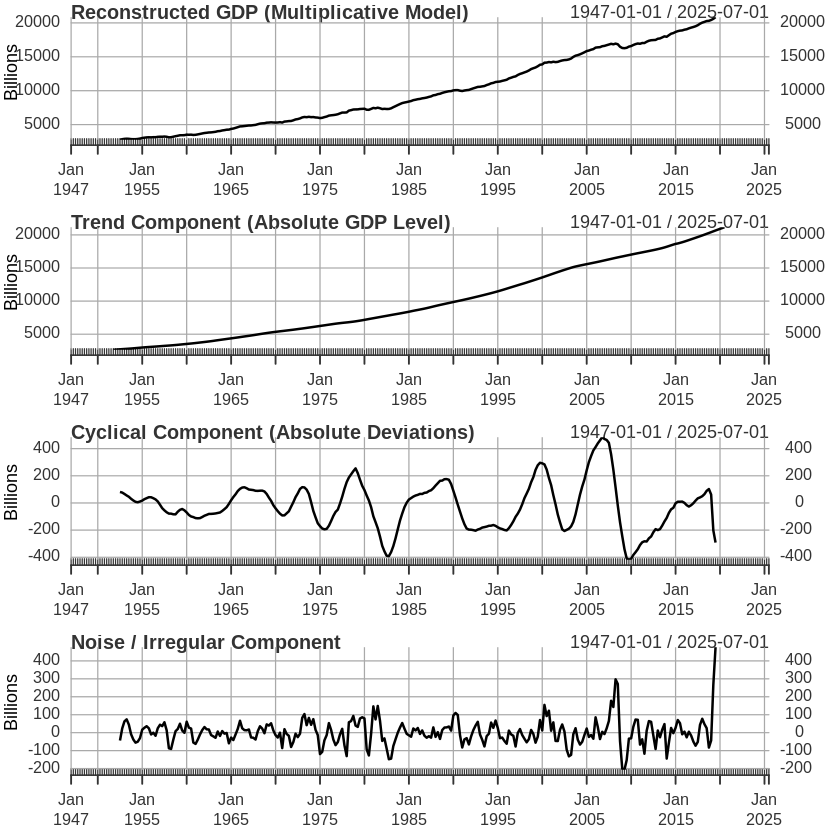

In [4]:
######### Loading libraries #########
install.packages("quantmod")
library(quantmod)



######### Load GDP data #########
# Quarterly Real GDP (GDPC1) from FRED,
# seasonally adjusted annual rate (SAAR), long historical span
getSymbols("GDPC1", src = "FRED")
GDP_time_series <- GDPC1


######### Multiplicative Decomposition #########
### Log-transform to convert multiplicative structure into additive components
log_gdp <- log(GDP_time_series)

plot(
  log_gdp,
  type = "l",
  main = "Log Real GDP",
  xlab = "Time",
  ylab = "log(GDP)"
)



######### Log Trend #########
### Structural long-run trend (log scale)
log_trend <- rollmean(log_gdp, k = 40, align = "center", fill = NA)

plot(
  log_gdp,
  type = "l",
  col = "grey50",
  lwd = 1,
  main = "Log GDP with Trend",
  xlab = "Time",
  ylab = "log(GDP)"
)

lines(
  log_trend,
  col = "red",
  lwd = 2
)

legend(
  "topleft",
  legend = c("Log Observed", "Log Trend"),
  col = c("grey50", "red"),
  lwd = c(1, 2),
  bty = "n"
)




######### Log Deviations (Cycles + Noise) #########
log_dev <- log_gdp - log_trend



######### Cycle and Noise #########
### Cycles: approx 2 years (8 quarters)
cycle <- rollmean(log_dev, k = 8, align = "center", fill = NA)

plot(
  log_dev,
  type = "l",
  col = "grey70",
  lwd = 1,
  main = "Log Deviations and Extracted Cycle",
  xlab = "Time",
  ylab = "Log Deviation"
)

lines(
  cycle,
  col = "firebrick",
  lwd = 2
)

abline(h = 0, col = "grey60", lty = 2)

legend(
  "topleft",
  legend = c("Log Deviations", "Cycle (8Q MA)"),
  col = c("grey70", "firebrick"),
  lwd = c(1, 2),
  bty = "n"
)

### Noise: residual
noise <- log_dev - cycle

plot(
  noise,
  type = "l",
  col = "grey50",
  lwd = 1,
  main = "Irregular Component (Residual)",
  xlab = "Time",
  ylab = "Residual (log scale)"
)

# Zero reference line
abline(h = 0, col = "black", lty = 2, lwd = 1)

# Optional: add horizontal bounds to guide scale perception
abline(h = c(-0.02, 0.02), col = "grey70", lty = 3)



######### Multiplicative Components (Absolute Scale) #########
trend_abs <- exp(log_trend)
cycle_abs <- trend_abs * (exp(cycle) - 1)
noise_abs <- trend_abs * (exp(noise) - 1)

### Reconstructed GDP
GDP_fitted <- exp(log_trend + cycle + noise)



######### Plot Decomposition #########
op <- par(no.readonly = TRUE)
par(mfrow = c(4, 1), mar = c(3, 4, 3, 2))

plot(
  GDP_fitted,
  type = "l",
  main = "Reconstructed GDP (Multiplicative Model)",
  ylab = "Billions",
  xlab = ""
)

plot(
  trend_abs,
  type = "l",
  main = "Trend Component (Absolute GDP Level)",
  ylab = "Billions",
  xlab = ""
)

plot(
  cycle_abs,
  type = "l",
  main = "Cyclical Component (Absolute Deviations)",
  ylab = "Billions",
  xlab = ""
)
abline(h = 0, lty = 2)

plot(
  noise_abs,
  type = "l",
  main = "Noise / Irregular Component",
  ylab = "Billions",
  xlab = "Time"
)
abline(h = 0, lty = 2)

par(op)


ADF test, Transformation of Time Series & ACF/PACF plots

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘quadprog’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "GDPC1"


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1797.63   -34.30     4.87    46.03  1072.92 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) 18.534484  17.864263   1.038  0.30032   
z.lag.1     -0.002378   0.007172  -0.332  0.74042   
tt           0.605424   0.496542   1.219  0.22369   
z.diff.lag1 -0.156276   0.057719  -2.708  0.00716 **
z.diff.lag2 -0.061486   0.058394  -1.053  0.29321   
z.diff.lag3 -0.028501   0.058494  -0.487  0.62644   
z.diff.lag4 -0.045812   0.057752  -0.793  0.42825   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 147.5 on 303 degrees of freedom
Multiple R-squared:  0.06826,	Adjusted R-squared:  0.04981 
F-statistic:   3.7 on 6 and 303 DF,  p-


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.087155 -0.004142  0.000278  0.004252  0.079962 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.006899   0.001053   6.553 2.42e-10 ***
z.lag.1     -0.904500   0.110234  -8.205 6.65e-15 ***
z.diff.lag1  0.019410   0.098890   0.196    0.845    
z.diff.lag2  0.127329   0.087893   1.449    0.148    
z.diff.lag3  0.113481   0.076040   1.492    0.137    
z.diff.lag4  0.050806   0.057186   0.888    0.375    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01102 on 303 degrees of freedom
Multiple R-squared:  0.4451,	Adjusted R-squared:  0.4359 
F-statistic: 48.61 on 5 and 303 DF,  p-value: < 2.2e-16


Value of test-statisti

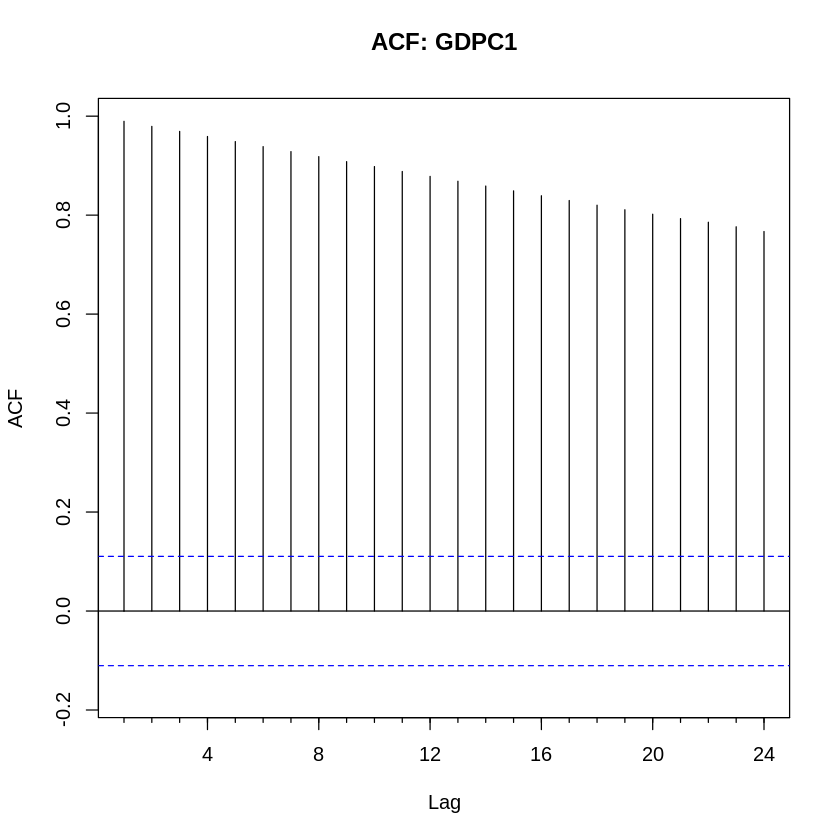

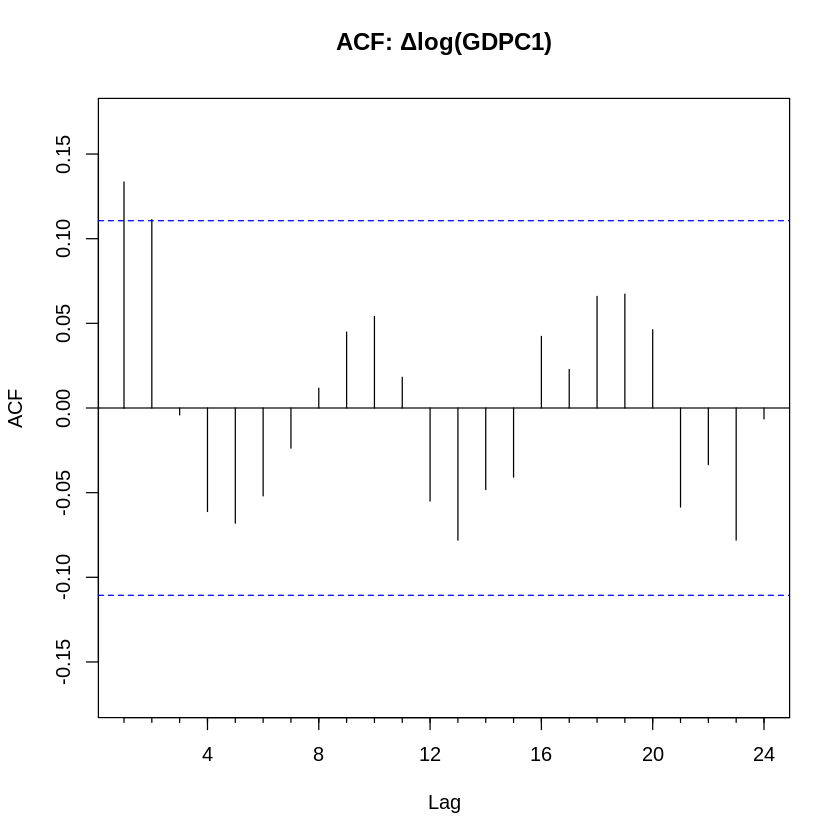

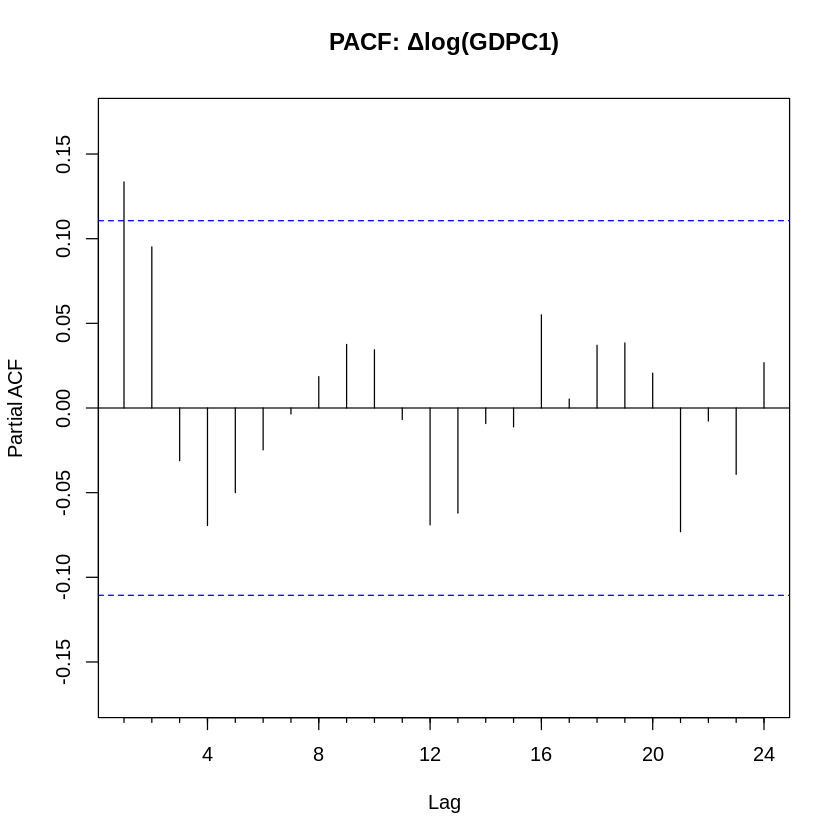

In [5]:
# package installation will take around ~ 5 minutes
install.packages("forecast")
install.packages("ggplot2")
install.packages("urca")

library(quantmod)
library(forecast)
library(ggplot2)

# Pull GDPC1 from FRED
getSymbols("GDPC1", src = "FRED")
y <- as.numeric(GDPC1)  # levels
y_ts <- ts(y, frequency = 4, start = c(1947, 1))


library(urca)
# ADF test on original time series
adf_ur_level_trend <- ur.df(y_ts, type = "trend", lags = 4)  # constant + trend
summary(adf_ur_level_trend)
# summary concludes time series contain unit root at 99% significance level

# --- Stationary transform: log-diff (approx GDP growth) ---
ly_ts <- log(y_ts)
dly_ts <- diff(ly_ts)  # log growth (stationary candidate)

# ADF test on transformed time series
adf_ur_dly_drift <- ur.df(dly_ts, type = "drift", lags = 4)   # constant only since trend removed after differencing
summary(adf_ur_dly_drift)
# null hypothesis rejected at 99% significance level

# ACF plot on original time series
Acf(y_ts, main = "ACF: GDPC1")

# ACF/PACF on stationary transform
Acf(dly_ts, main = "ACF: Δlog(GDPC1)")
Pacf(dly_ts, main = "PACF: Δlog(GDPC1)")

Forecast Models

Series: dly_ts 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
      0.1335  0.0076
s.e.  0.0559  0.0007

sigma^2 = 0.0001212:  log likelihood = 971.3
AIC=-1936.6   AICc=-1936.53   BIC=-1925.35

Training set error measures:
                       ME       RMSE         MAE       MPE     MAPE      MASE
Training set 4.666895e-06 0.01097338 0.006814169 -131.7078 266.6482 0.6381093
                    ACF1
Training set -0.01266384

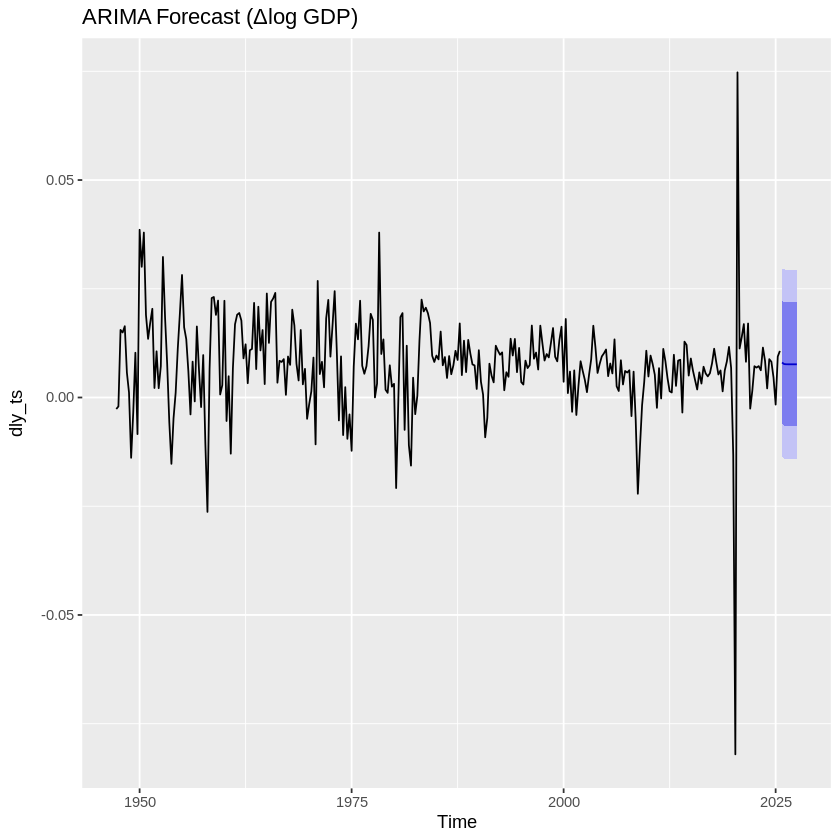

In [ ]:
# -------------------------------
# Confirmation step (software)
# -------------------------------
auto_model <- auto.arima(
  dly_ts,
  d = 0, #already differenced
  seasonal = FALSE
)
summary(auto_model)

# -------------------------------
# Forecast with auto.arima model
# -------------------------------
h <- 8  # forecast horizon (8 quarters)

auto_fc <- forecast(auto_model, h = h)
autoplot(auto_fc) +
  ggtitle("ARIMA Forecast (Δlog GDP)")

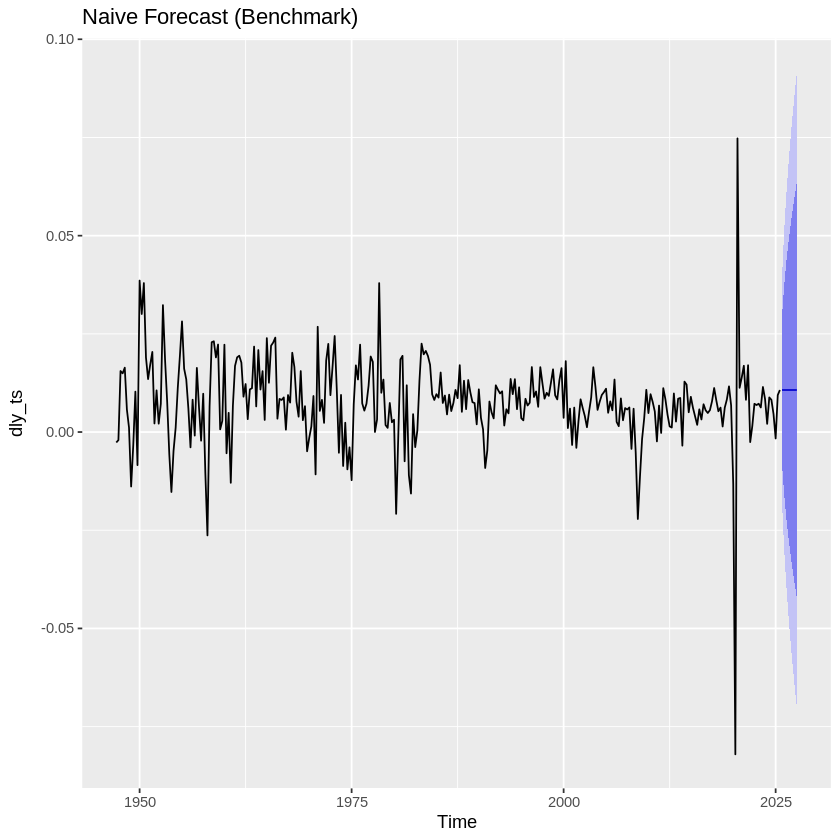

In [ ]:
# -------------------------------
# Baseline: Naive forecast
# -------------------------------
naive_fc <- naive(dly_ts, h = h)
autoplot(naive_fc) +
  ggtitle("Naive Forecast (Benchmark)")

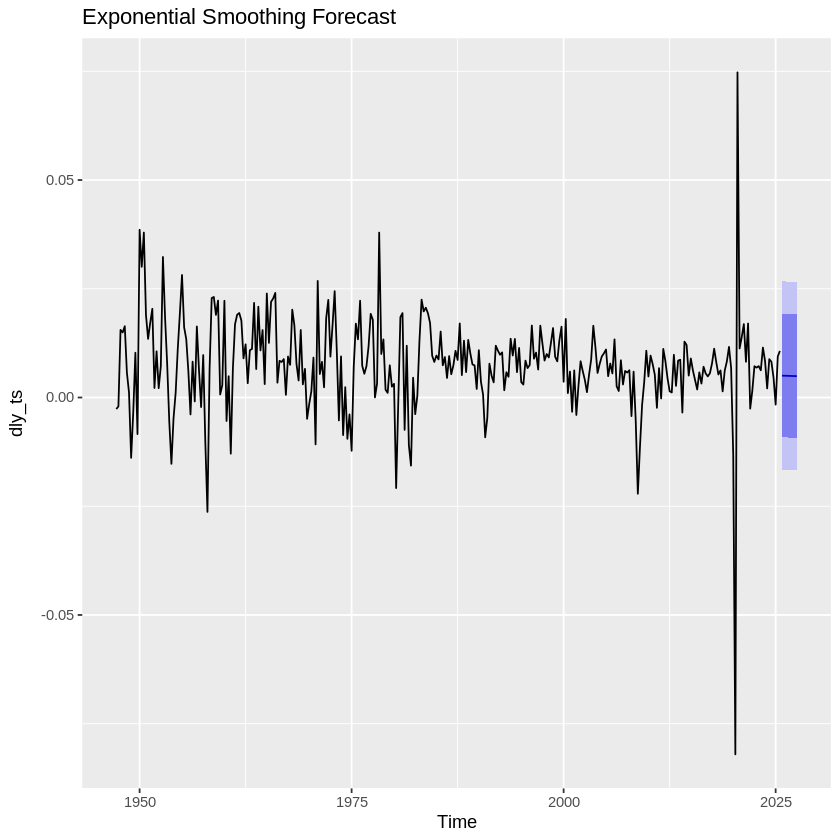

In [ ]:
# -------------------------------
# Exponential smoothing forecast
# -------------------------------
ets_model <- ets(dly_ts)
ets_fc <- forecast(ets_model, h = h)
autoplot(ets_fc) +
  ggtitle("Exponential Smoothing Forecast")


In [ ]:
# -------------------------------
# Compare forecast accuracy
# -------------------------------
accuracy(auto_fc)
accuracy(naive_fc)
accuracy(ets_fc)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,4.666895e-06,0.01097338,0.006814169,-131.7078,266.6482,0.6381093,-0.01266384


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,4.268918e-05,0.01458732,0.008584315,-288.466,441.4022,0.8038738,-0.4878788


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-3.17322e-05,0.01099111,0.006990362,-116.6761,260.0027,0.6546089,0.1192632
